# Machine Learning Experiments with Sacred



## About me

### Hi, I amRüdiger

### GitHub: JarnoRFB

<br/>
<div style="float:left">
<div style="width: 35%; float:left">
<img src="http://computational-cognition.eu/files/header.jpg"/>
    <p><b>Neuroinformatics Group Osnabrück</b></p>
</div>
<div style="width: 55%;float:right">
<img src="http://www.sialon.eu/data2/images/63_Logo_Germany_RobertKoch.jpg"/>
</div>
</div>

## Let's try to solve a classic machine learning problem!
* Let's take the breast cancer dataset from scikit-learn.
* It describes 30 numeric features of the cell nuclei. 
* The target is to figure out, whether the cells are benign or a malignant turmor.

In [1]:
import os
import pandas as pd
from sklearn import svm, datasets, model_selection

In [2]:
dataset = datasets.load_breast_cancer()
data = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Nothing easier than that! We just split the data into training and test set, and throw a standard Support Vector Machine at the problem. 

In [3]:
X, y = datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

clf = svm.SVC(C=3, kernel='rbf', gamma=0.7)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.6052631578947368

Next we try to tune the parameters a bit to get optimal performance.

However, after some time we start to forget what combinations we tried already and what the actual results where...

## Sacred to the rescue


> Every experiment is sacred <br/>
> Every experiment is great <br/>
> If an experiment is wasted <br/>
> God gets quite irate <br/>

 &mdash; Modified after *Monty Python's The Meaning of Life*
 
[sacred](https://github.com/IDSIA/sacred) is a library that helps you to keep track of your machine learning experiments.

In [4]:
from sacred import Experiment

ex = Experiment(
    name='svm', 
    interactive=True,  # Because we are running in IPython.
)

In [5]:
@ex.config
def cfg():
    C = 1.0
    gamma = 0.7
    kernel = 'rbf'
    seed = 42  # Add a seed to the config for more determinism.


In [6]:
@ex.main
def run(C, kernel, gamma):
    X, y = datasets.load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

    clf = svm.SVC(C, gamma=gamma, kernel=kernel)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [7]:
ex.run()

WARNING - svm - No observers have been added to this run
INFO - svm - Running command 'run'
INFO - svm - Started
INFO - svm - Result: 0.6228070175438597
INFO - svm - Completed after 0:00:00


## Modularizing using captured functions

The `ex.capture` decorator injects the config into the function. We can call caputured functions without explicitly passing the arguments later on.

In [8]:
ex = Experiment('svm', interactive=True)

@ex.config
def cfg():
    C = 1.0
    gamma = 0.7
    kernel = 'rbf'
    seed = 42
    
@ex.capture
def get_model(C, gamma, kernel):
    return svm.SVC(C=C, kernel=kernel, gamma=gamma)
    
@ex.main
def run():  # Now we don't have to pass parameters to run anymore.
    X, y = datasets.load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
    clf = get_model()  # Parameter from the config are automatically injected.
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

ex.run()

WARNING - svm - No observers have been added to this run
INFO - svm - Running command 'run'
INFO - svm - Started
INFO - svm - Result: 0.6228070175438597
INFO - svm - Completed after 0:00:00


## Adding Observers
By adding observers, we can store configurations and results of experiments into a database, preferably MongoDB.

In [9]:
# Load some environment variables, to match the docker environment.
from dotenv import load_dotenv
env_path = 'sacred_setup/.env'
load_dotenv(dotenv_path=env_path)

True

In [10]:
db_name = os.environ['MONGO_DATABASE']
mongo_uri = (f'mongodb://{os.environ["MONGO_INITDB_ROOT_USERNAME"]}:'
             f'{os.environ["MONGO_INITDB_ROOT_PASSWORD"]}@localhost:27017/?authMechanism=SCRAM-SHA-1')

In [11]:
from sacred.observers import MongoObserver

ex = Experiment('svm', interactive=True)

ex.observers.append(
    MongoObserver.create(
        url=mongo_uri,
        db_name=db_name,
    )
)

In [12]:
@ex.config
def cfg():
    C = 1.0
    gamma = 0.7
    kernel = 'rbf'
    seed = 42
    
@ex.main
def run(C, kernel, gamma):
    X, y = datasets.load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

    clf = svm.SVC(C, gamma=gamma, kernel=kernel)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

ex.run()
# The "No observers have been added to this run" warning vanishes.

INFO - svm - Running command 'run'
INFO - svm - Started run with ID "14"
INFO - svm - Result: 0.6228070175438597
INFO - svm - Completed after 0:00:00


Now we can view the result in a dashboard like [Omniboard](https://github.com/vivekratnavel/omniboard). Go to http://localhost:9000/ to see the how it looks.

## Recording metrics and artifacts
We can attach metrics and even entire files as artifacts to our experiments.

In [13]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix


def plot_confusion_matrix(confusion_matrix, class_names):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig, ax = plt.subplots()
    heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")
    heatmap.set(ylabel='True label', xlabel='Predicted label')

    return fig

In [14]:
ex = Experiment('svm', interactive=True)

ex.observers.append(MongoObserver.create(
    url=mongo_uri,
    db_name=db_name))

@ex.config
def cfg():
    C = 1.0
    gamma = 0.7
    kernel = 'linear'
    seed = 42
    
@ex.capture
def get_model(C, gamma, kernel):
    return svm.SVC(C=C, kernel=kernel, gamma=gamma)

INFO - svm - Running command 'run'
INFO - svm - Started run with ID "15"
INFO - svm - Result: 0.956140350877193
INFO - svm - Completed after 0:00:01


Added image/png as content-type of artifact /home/jarno/projects/pydata_berlin_sacred/confusion_matrix.png.


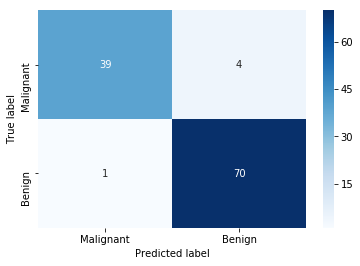

In [15]:
@ex.main
def run(C, kernel, gamma, _run):
    X, y = datasets.load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

    clf = get_model()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # Plot the confusion matrix and store it as PNG.             
    cm_filename = 'confusion_matrix.png' 
    confusion = confusion_matrix(y_test, y_pred, labels=[False, True])
    fig = plot_confusion_matrix(confusion, class_names=['Malignant', 'Benign'])
    fig.savefig(cm_filename)
    # Save the artifact.
    _run.add_artifact(cm_filename)
    # Save the F1 score as a metric.
    _run.log_scalar('F1', f1_score(y_test, y_pred))
             
    return clf.score(X_test, y_test)

ex.run()

## Retrieving results using incense
Once we are done conducting our experiments, we can get the results back into Python using [incense](https://github.com/JarnoRFB/incense). This is especially useful for organizing results in a comprehensive way.

In [16]:
from incense import ExperimentLoader

loader = ExperimentLoader(
    mongo_uri=mongo_uri,
    db_name=db_name,
)

In [17]:
exp = loader.find_by_id(1)
exp

Experiment(id=1, name=svm)

In [18]:
exp.config

{'C': 1.0, 'gamma': 0.7, 'kernel': 'rbf', 'seed': 42}

In [19]:
exp.result

0.6228070175438597

In [20]:
exp = loader.find_by_config_key('kernel', 'linear')[0]

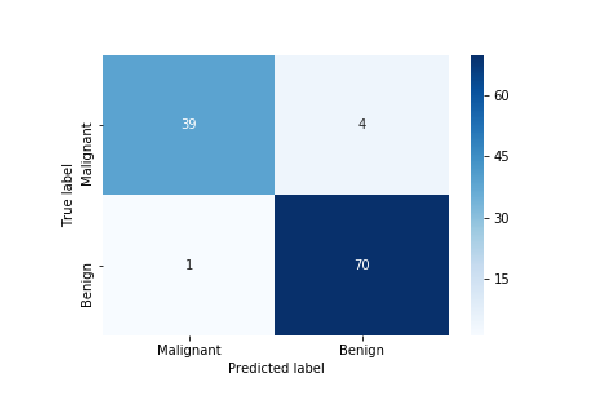

In [21]:
exp.artifacts['confusion_matrix.png'].show();

In [22]:
exp.metrics['F1']

step
0    0.965517
Name: F1, dtype: float64

## Conclusion
Don't waste time and resources on unreproducible experiments! Sacred will give you the necessary structure to find out which machine learning models are the right ones for you.  

## Contributing
Issues, feature and pull requests highly welcome! Just visit https://github.com/IDSIA/sacred

## Thanks!

## Questions?